In [59]:
%matplotlib inline
import pymongo

import numpy as np
import pandas as pd

import seaborn as sns
# import bokeh
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [147]:
# Configuration of the database
client = pymongo.MongoClient("mongodb://localhost:27017/")
database = client['thesis']
db = database['dumps']

boards_ids = list(set(i['board_id'] for i in db.find({},{"_id": 0, "board_id": 1})))

print(boards_ids)

['0x30314710303537323E0372', '0x30314717373435343003E0']


In [148]:
# Configuration of matplotlib
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=15) 
plt.rc('figure', titlesize=19)

plt.rcParams['figure.figsize'] = [29, 10]  # Scale up plots 

In [157]:
def add_to_off(address, starting_address=0x20000000, dump_size=512):
    '''Convert a memory address into an index.'''
    if isinstance(address, str):
        address = int(mem_address, 16)
    if isinstance(starting_address, str):
        starting_address = int(starting_address, 16)
        
    return (address - starting_address) // dump_size


def off_to_add(offset, starting_address=0x20000000, dump_size=512):
    '''Convert an offset into a memory address.'''
    if isinstance(starting_address, str):
        starting_address = int(starting_address, 16)
        
    return hex(offset * dump_size + starting_address)

In [173]:
def plot_memory_regions(board_id, offset=0, mem_ending_pos=32, chunk_size=512, show_every=False):
    '''
    Scatter plot of memory dumps.
    X axis is the address and the Y axis is the value at that address.
    '''  
    mem_pos, mem_off, mem_val = [], [], []
    color_boards = {boards_ids[0]: 'g', boards_ids[1]: 'b'}
    
    dumps_list = list(db.find({"board_id": board_id}))
    starting_address = off_to_add(offset)
    
    
    for plot in range(offset, mem_ending_pos):
        mem_val = dumps_list[plot]['data']
        mem_off = dumps_list[plot]['mem_pos']
        mem_pos = [int(mem_off, 16) + i for i in range(0, chunk_size)]

        # Generate the plot
        plt.scatter(mem_pos, mem_val, marker='x', color=color_boards[board_id])
        plt.xlabel('Memory address')
        plt.ylabel('Values')
                         
        if show_every:
            plt.title('[' + board_id + '] Memory map at ' + str(mem_off))
        else:
            ending_address = off_to_add(mem_ending_pos)
            plt.title('[' + board_id + '] Memory map from ' + \
                      str(starting_address) + ' to ' + str(ending_address))
            
        ax = plt.gca()
        plt.ylim((0, 270))
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(16))
        ax.yaxis.set_major_locator(plt.MaxNLocator(25))
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))

        xlabels = map(lambda t: '0x%08X' % int(t), ax.get_xticks())  # Show x axis as hex numbers
        ax.set_xticklabels(xlabels, rotation=45, horizontalalignment='right');
        
        plt.grid()
        
        # Show every plot or all of the data combined in one
        if show_every:
            plt.show() 

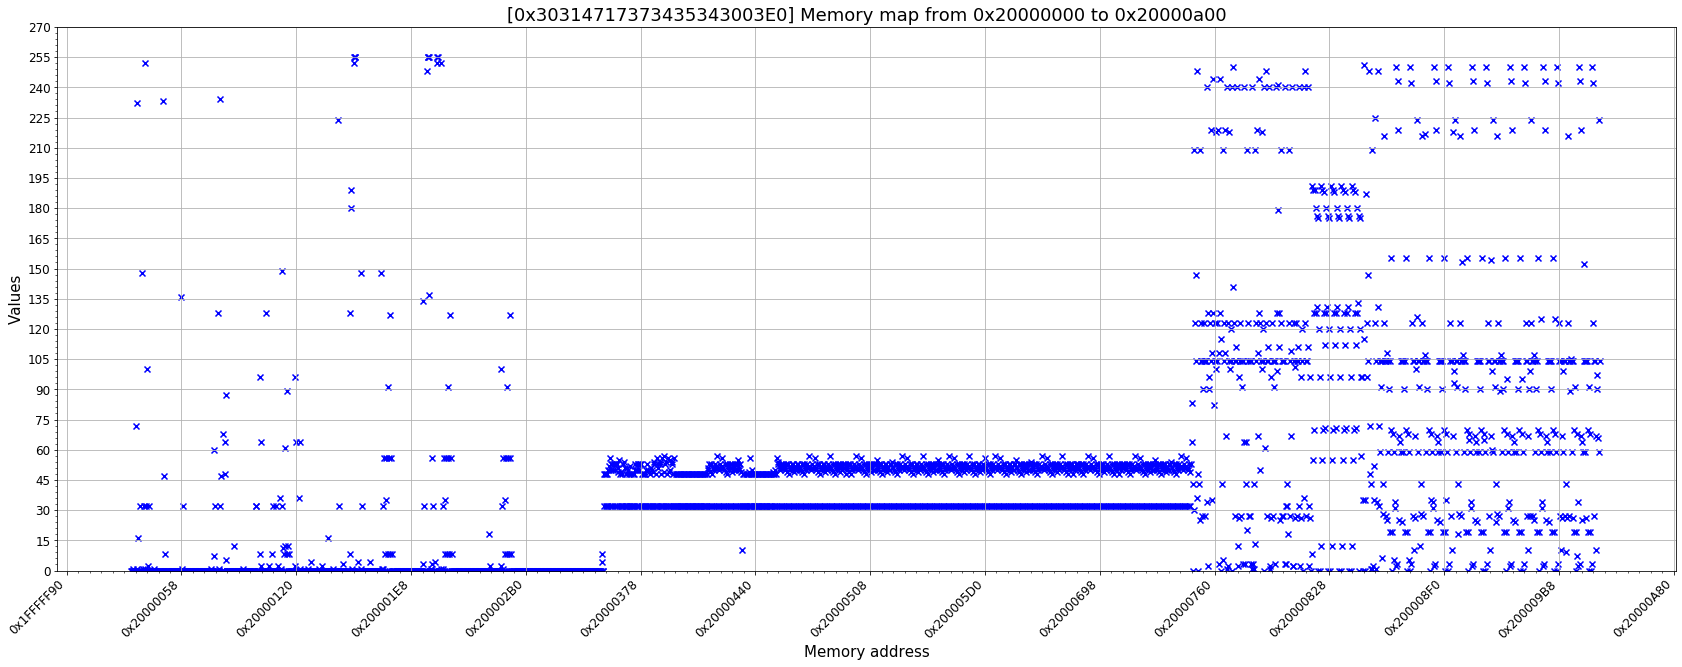

In [182]:
plot_memory_regions(boards_ids[1], 0, 5, show_every=False)

In [177]:
from itertools import combinations

def calculate_diff(sample1, sample2):
    '''
    Given two dumps of data, calculate the difference between their data.
    '''
    diff = 0
    for i in range(sample1['length']):
        if sample1['data'][i] != sample2['data'][i]:
            diff = diff + 1
    
    diff = diff / int(sample1['length'])
    return (diff * 100)


def compare_dumps(board_id, board_dumps):
    '''
    Given a pair of dumps, calculate the difference in % between them.
    Outputs the board_id, the memory position and the difference in the data.
    '''
    memory_groups = []
    column_names = ["Board", "Region", "Id_1", "Id_2", "Diff"]
    df = pd.DataFrame(columns=column_names)
    
    # Every possible starting memory address
    memory_regions = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))
    
    # There are 32 groups, one per region of memory
    for region in memory_regions:
        
        region_samples = list(db.find({"mem_pos": region, "board_id": board_id}))
        region_samples = list(combinations(region_samples, 2))
        
        # Cycle through all of the samples of that memory region
        for i, (sample1, sample2) in enumerate(region_samples):
            diff = calculate_diff(sample1, sample2)
                
            data = {'Board': board_id,
                    'Region': region,
                    'Id_1': str(sample1['_id']),
                    'Id_2': str(sample2['_id']),
                    'Diff': diff}
            df = df.append(data, ignore_index=True)

    return df


def filter_results(data_frame, lower_thresh, upper_thresh, column='Diff'):
    '''
    Filter the results of a data frame.
    The new data frame has values between the given thresholds.
    '''
    is_valid = data_frame[column] > lower_thresh
    data_frame = data_frame[is_valid]
    
    is_valid = data_frame[column] < upper_thresh
    data_frame = data_frame[is_valid]
    
    return data_frame

In [178]:
board_dumps = list(db.find({"board_id": boards_ids[0]}))

data = compare_dumps(boards_ids[0], board_dumps)
data_valid = filter_results(data, 9.0, 20.0)

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

data_valid.sort_values(['Diff'], ascending=[True], inplace=True)
data_valid

,Board,Region,Id_1,Id_2,Diff
486,0x30314710303537323E0372,0x20000600,5db99b53ddc2ad5d58d20446,5db99b9dddc2ad5d58d204c6,9.179688
483,0x30314710303537323E0372,0x20000600,5db99b53ddc2ad5d58d20446,5db99b65ddc2ad5d58d20466,9.179688
480,0x30314710303537323E0372,0x20000600,5db99b46ddc2ad5d58d20426,5db99b9dddc2ad5d58d204c6,9.179688
473,0x30314710303537323E0372,0x20000600,5db99af9ddc2ad5d58d20406,5db99b9dddc2ad5d58d204c6,9.179688
494,0x30314710303537323E0372,0x20000600,5db99b72ddc2ad5d58d20486,5db99b7dddc2ad5d58d204a6,9.179688
499,0x30314710303537323E0372,0x20000600,5db99b7dddc2ad5d58d204a6,5db99baeddc2ad5d58d204e6,9.375000
485,0x30314710303537323E0372,0x20000600,5db99b53ddc2ad5d58d20446,5db99b7dddc2ad5d58d204a6,9.375000
500,0x30314710303537323E0372,0x20000600,5db99b7dddc2ad5d58d204a6,5db99d3eddc2ad5d58d20506,9.375000
489,0x30314710303537323E0372,0x20000600,5db99b65ddc2ad5d58d20466,5db99b72ddc2ad5d58d20486,9.570312
498,0x30314710303537323E0372,0x20000600,5db99b7dddc2ad5d58d204a6,5db99b9dddc2ad5d58d204c6,9.570312


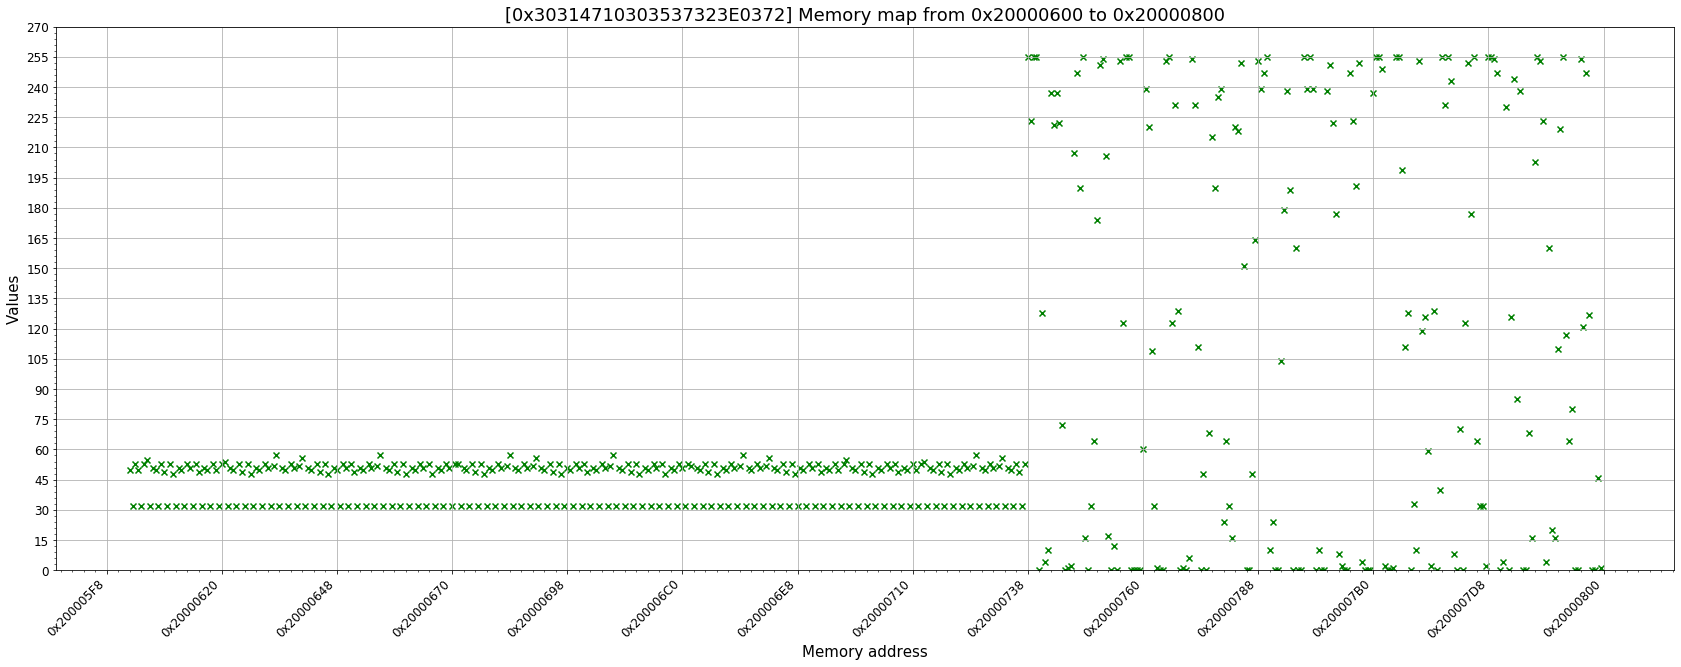

In [180]:
plot_memory_regions(boards_ids[0], 3, 4, show_every=False)

In [144]:
board_dumps = list(db.find({"board_id": boards_ids[1]}))

data = compare_dumps(boards_ids[1], board_dumps)
data_valid = filter_results(data, 8.0, 18.0)

data_valid.sort_values(['Diff'], ascending=[True], inplace=True)
data_valid

,Board,Region,Id_1,Id_2,Diff
880,0x30314717373435343003E0,0x20000600,5db98474e0b8db926ee82c41,5db984ebe0b8db926ee82c81,10.156250
872,0x30314717373435343003E0,0x20000600,5db9846ce0b8db926ee82c21,5db98598e0b8db926ee82ca1,10.742188
907,0x30314717373435343003E0,0x20000600,5db98598e0b8db926ee82ca1,5db99a75e0b8db926ee82d41,10.937500
886,0x30314717373435343003E0,0x20000600,5db98474e0b8db926ee82c41,5db99a75e0b8db926ee82d41,11.132812
881,0x30314717373435343003E0,0x20000600,5db98474e0b8db926ee82c41,5db98598e0b8db926ee82ca1,11.328125
870,0x30314717373435343003E0,0x20000600,5db9846ce0b8db926ee82c21,5db9847ee0b8db926ee82c61,11.523438
898,0x30314717373435343003E0,0x20000600,5db984ebe0b8db926ee82c81,5db985c4e0b8db926ee82ce1,11.523438
887,0x30314717373435343003E0,0x20000600,5db98474e0b8db926ee82c41,5db99a84e0b8db926ee82d61,11.523438
891,0x30314717373435343003E0,0x20000600,5db9847ee0b8db926ee82c61,5db985c4e0b8db926ee82ce1,11.718750
876,0x30314717373435343003E0,0x20000600,5db9846ce0b8db926ee82c21,5db99a66e0b8db926ee82d21,11.718750


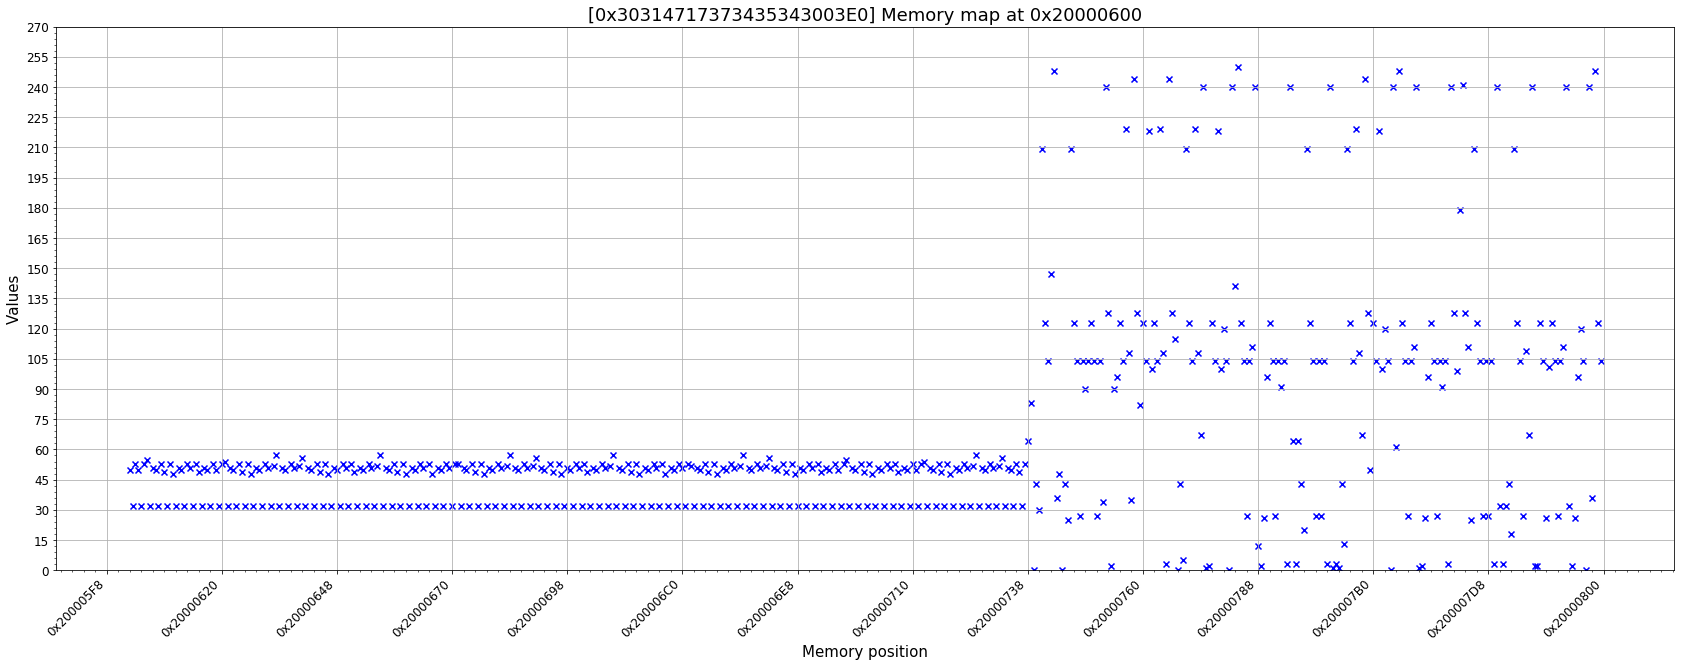

In [93]:
plot_memory_regions(boards_ids[1], 3, 4, show_every=False)

In [94]:
# Compare the same memory region in different boards
# region_uut = '0x20002600'

memory_regions_uut = list(set([mem_pos['mem_pos'] for mem_pos in board_dumps]))
final_column_names = ["Board_1", "Board_2", "Region", "Id_1", "Id_2", "Diff"]

fdata_df = pd.DataFrame(columns=final_column_names)
    
for region_uut in memory_regions_uut:
    dumps_board_0 = list(db.find({'mem_pos': region_uut, 'board_id': boards_ids[0]}))
    dumps_board_1 = list(db.find({'mem_pos': region_uut, 'board_id': boards_ids[1]}))

    num_samples = min(len(dumps_board_0), len(dumps_board_1))

    for sample in range(num_samples):
        diff = calculate_diff(dumps_board_0[sample], dumps_board_1[sample])
    
        data = {'Board_1': dumps_board_0[sample]['board_id'],
                'Board_2': dumps_board_1[sample]['board_id'],
                'Region': region_uut,
                'Id_1': str(dumps_board_0[sample]['_id']),
                'Id_2': str(dumps_board_1[sample]['_id']),
                'Diff': diff}
    
        fdata_df = fdata_df.append(data, ignore_index=True)

final_is_valid = fdata_df['Diff'] < 70
fdata_df = fdata_df[final_is_valid]

fdata_df.sort_values(['Diff'], ascending=[True], inplace=True)
fdata_df

,Board_1,Board_2,Region,Id_1,Id_2,Diff
54,0x30314710303537323E0372,0x30314717373435343003E0,0x20000400,5db99af9ddc2ad5d58d20405,5db98443e0b8db926ee82c00,0.000000
116,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99d3dddc2ad5d58d20504,5db98e5fe0b8db926ee82cff,0.000000
115,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99badddc2ad5d58d204e4,5db985c4e0b8db926ee82cdf,0.000000
114,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99b9dddc2ad5d58d204c4,5db985a8e0b8db926ee82cbf,0.000000
113,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99b7dddc2ad5d58d204a4,5db98598e0b8db926ee82c9f,0.000000
112,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99b72ddc2ad5d58d20484,5db984ebe0b8db926ee82c7f,0.000000
110,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99b53ddc2ad5d58d20444,5db98474e0b8db926ee82c3f,0.000000
109,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99b46ddc2ad5d58d20424,5db9846be0b8db926ee82c1f,0.000000
108,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99af9ddc2ad5d58d20404,5db98442e0b8db926ee82bff,0.000000
111,0x30314710303537323E0372,0x30314717373435343003E0,0x20000200,5db99b64ddc2ad5d58d20464,5db9847ee0b8db926ee82c5f,0.000000


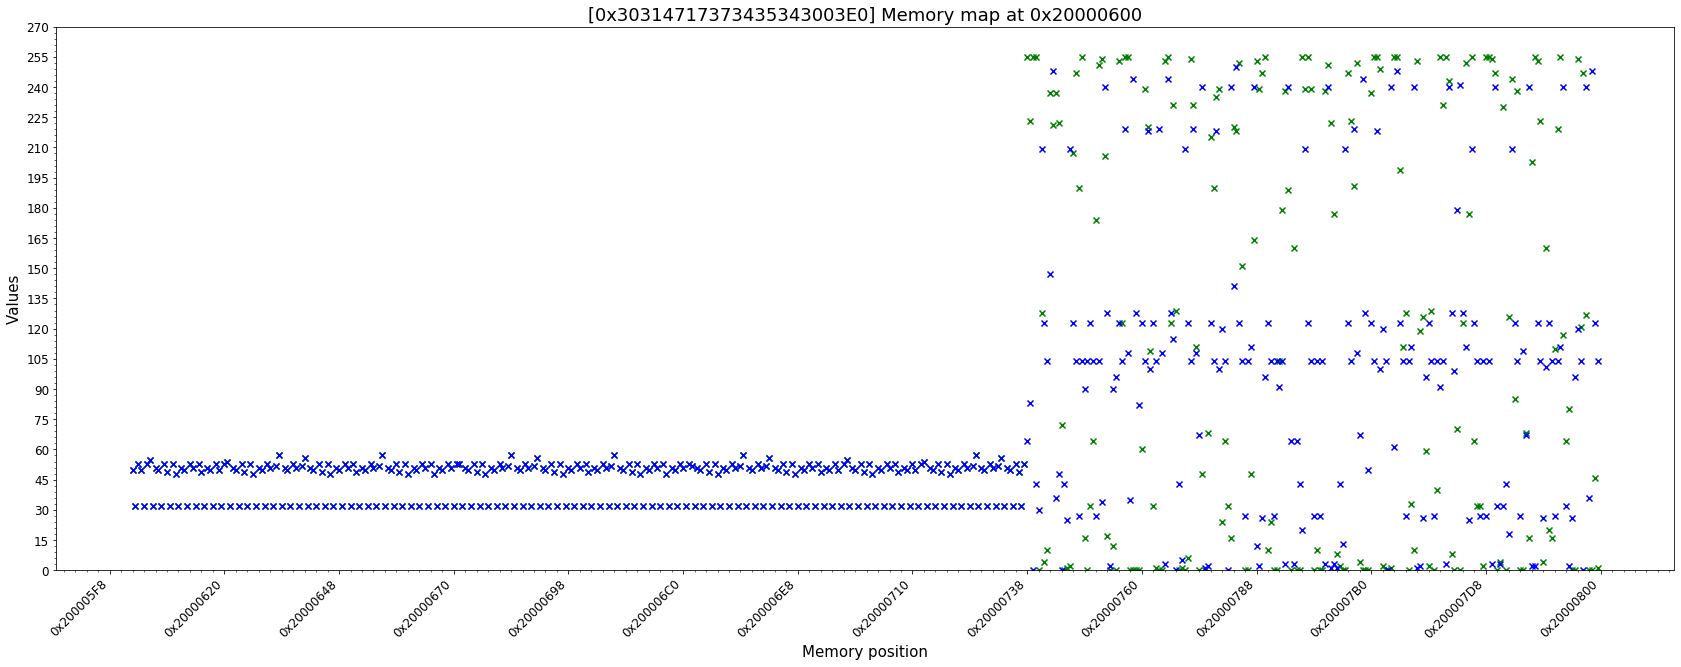

In [139]:
for board in boards_ids:
    plot_memory_regions(board, 3, 4, show_every=False)